https://analyticsindiamag.com/a-hands-on-guide-to-anomaly-detection-in-time-series-using-adtk/

#### 1. ADTK (Anomaly detection toolkit) 시계열 이상탐지 오픈소스
    - ADTK란 ?
        : 과거 데이터에서 비정상 데이터를 거의 찾지 못하고 지도 모델을 구축하는 데 문제 있음
        : 관심 있는 이벤트 유형을 이해하기 위해 항상 비정상을 감지해야 하는 요구 사항 있음
    
        - 이상값 감지기            
            : 데이터에서 이상값을 감지
            : 임계값 감지, 계절 감지, 회귀 감지 등과 같은 시계열의 모든 유형의 감지에 도움이 되는 다양한 모듈
            
        - 변환기
            : 데이터를 변환
            : 이 클래스에는 롤링 집계, 계절 분해 등의 모듈과 같은 다양한 모듈
            
        - 규칙 체인 집계기
            : 모든 규칙에 따라 설정된 시점을 식별하고 집계

#### 1. 데이터 로드

In [2]:
!pip install yfinance

^C


- 주가 시가, 고가, 저가 및 종가와 주식의 거래량이 변수

In [120]:
import datetime as dt
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import yfinance as yf

end = dt.today()
start = dt.today() - relativedelta(years=1)
data = yf.download('SBIN.NS', start, end)
data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-29,511.299988,517.000000,508.750000,514.849976,514.849976,9421339
2022-08-30,518.200012,532.500000,517.950012,531.250000,531.250000,14835308
2022-09-01,522.250000,540.900024,522.250000,533.299988,533.299988,16670228
2022-09-02,537.000000,537.849976,531.250000,536.700012,536.700012,10017930
2022-09-05,537.000000,540.799988,536.299988,538.900024,538.900024,7814769


In [121]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

#### 2. 데이터 전처리

- 주식 시장이 열리지 않는 주말이 있음!
    - 이 격차를 메워야 하지만 그 전에 데이터에 누락된 날짜가 몇 개인지 확인

- 결측치 개수 ! (밑)

In [122]:
import pandas as pd

# pandas.date_range() : 고정 빈도 DatetimeIndex를 반환하는 데 사용되는 Pandas의 일반 함수
pd.date_range(start = start, end = end ).difference(data.index)
# difference : data의 columns에서 분리해내는 method

DatetimeIndex(['2021-09-06 09:43:10.049840', '2021-09-07 09:43:10.049840',
               '2021-09-08 09:43:10.049840', '2021-09-09 09:43:10.049840',
               '2021-09-10 09:43:10.049840', '2021-09-11 09:43:10.049840',
               '2021-09-12 09:43:10.049840', '2021-09-13 09:43:10.049840',
               '2021-09-14 09:43:10.049840', '2021-09-15 09:43:10.049840',
               ...
               '2022-08-27 09:43:10.049840', '2022-08-28 09:43:10.049840',
               '2022-08-29 09:43:10.049840', '2022-08-30 09:43:10.049840',
               '2022-08-31 09:43:10.049840', '2022-09-01 09:43:10.049840',
               '2022-09-02 09:43:10.049840', '2022-09-03 09:43:10.049840',
               '2022-09-04 09:43:10.049840', '2022-09-05 09:43:10.049840'],
              dtype='datetime64[ns]', length=365, freq=None)

In [125]:
idx = pd.date_range(start, end)

# reindex : 특정 축을 다라 입력된 배열에 다라 데이터 순서를 조정
data = data.reindex(idx)
# fillna : DataFrame에서 결측값을 원하는 값으로 변경
# ffill : 결측값이 바로 위값과 동일하게 설정
data.fillna(method="ffill", inplace = True)

In [126]:
data

,Open,High,Low,Close,Adj Close,Volume
2021-09-06 09:43:10.049840,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-07 09:43:10.049840,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-08 09:43:10.049840,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-09 09:43:10.049840,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-10 09:43:10.049840,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-09-01 09:43:10.049840,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-02 09:43:10.049840,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-03 09:43:10.049840,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-04 09:43:10.049840,NaN,NaN,NaN,NaN,NaN,NaN


- 결측치 없앰 ! (밑)

In [127]:
pd.date_range(start = start, end = end ).difference(data.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [130]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN


#### 3. 데이터 검증 및 시각화

In [116]:
# 비지도/규칙 기반 시계열 이상 탐지를 위한 Python 패키지
from adtk.data import validate_series

data = validate_series(data)
print(data)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-09-06  432.000000  433.850006  430.049988  431.049988  424.426331   
2021-09-07  431.049988  431.700012  425.100006  429.100006  422.506317   
2021-09-08  429.000000  435.399994  427.350006  431.350006  424.721741   
2021-09-09  430.250000  433.799988  430.000000  432.299988  425.657135   
2021-09-13  430.100006  433.799988  428.799988  432.850006  426.198700   
...                ...         ...         ...         ...         ...   
2022-08-29  511.299988  517.000000  508.750000  514.849976  514.849976   
2022-08-30  518.200012  532.500000  517.950012  531.250000  531.250000   
2022-09-01  522.250000  540.900024  522.250000  533.299988  533.299988   
2022-09-02  537.000000  537.849976  531.250000  536.700012  536.700012   
2022-09-05  537.000000  540.799988  536.299988  538.900024  538.900024   

              Volume  
Date          

- 시각화

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

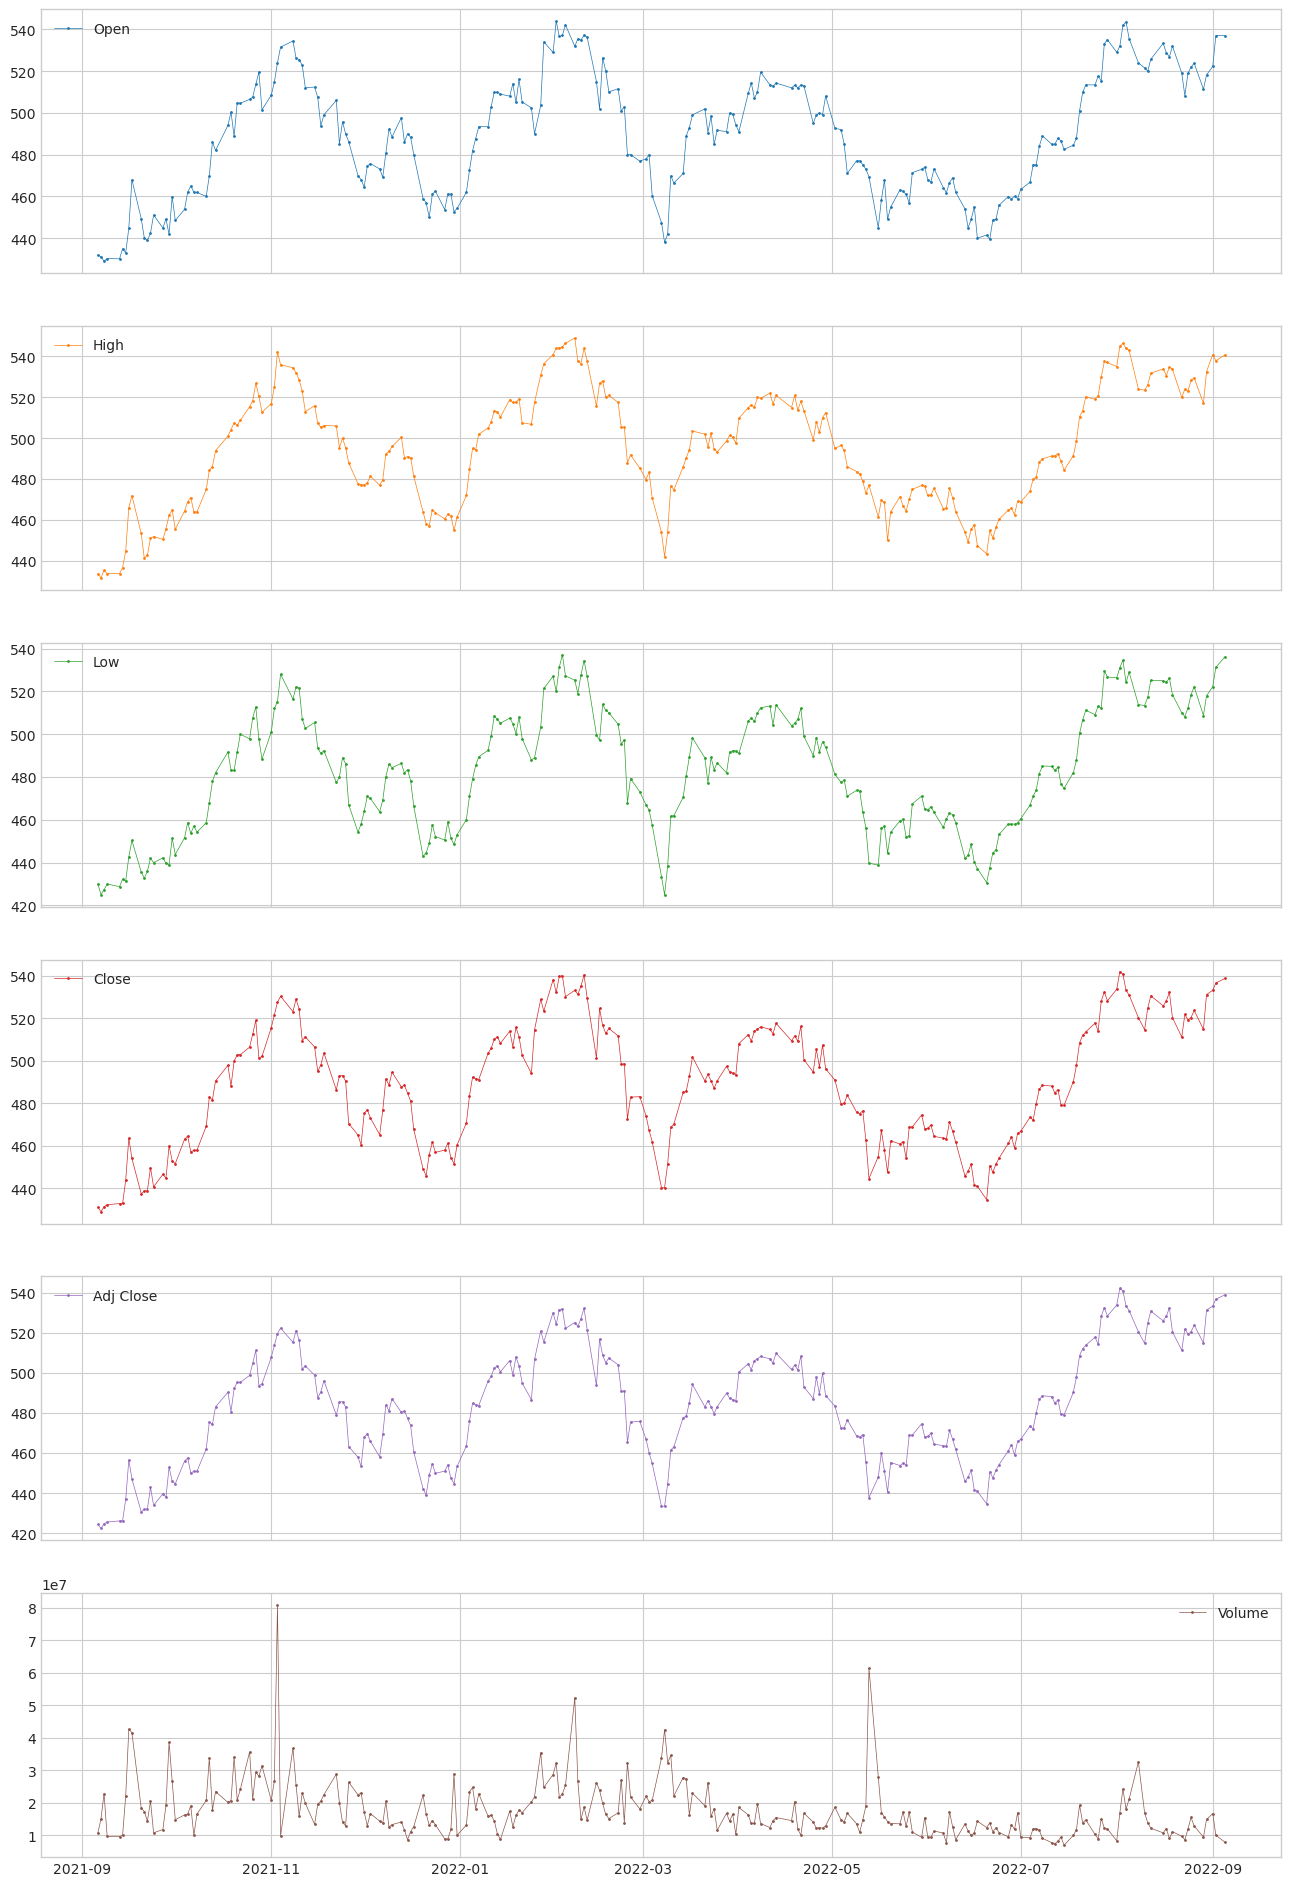

In [117]:
from adtk.visualization import plot

plot(data)

#### 4. 계절적 이상 탐지 
- 이상 현상 및 볼륨 변수에 의한 계절 패턴 위반을 감지

In [ ]:
from adtk.detector import SeasonalAD

seasonal_vol = SeasonalAD()
anomalies = seasonal_vol.fit_detect(data['Volume'])
anomalies.value_counts()

In [ ]:
plot(data, anomaly=anomalies, anomaly_color="orange", anomaly_tag="marker")

#### 5. 임계값 감지
- 시계열이 이 임계값을 벗어나는 지점을 감지

In [ ]:
print('Average closing price', data['Close'].mean())
print('Minimum closing price', data['Close'].min())
print('Maximum closing price',data['Close'].max())

In [ ]:
from adtk.detector import ThresholdAD
threshold_val = ThresholdAD(high=530, low=180)
anomalies_thresh = threshold_val.detect(data['Close'])

- 이상징후가 무엇인가?
    - True 개수

In [ ]:
anomalies_thresh.value_counts()

- 시각화

In [ ]:
from adtk.visualization import plot
plot(data, anomaly=anomalies_thresh, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='black');